# 2D FDTD with fdtdx: Plane Source & Cylinder

In this notebook we simulate a **2D electromagnetic problem** by using a 3-cell extruded geometry:
- The simulation volume is 3 cells thick in the **third (z) axis**.
- Cells at index 0 and 2 in z have **periodic boundaries** to mimic 2D.
- All objects are uniform in the z-direction so the fields also behave 2D.

Note: Some special sources (mode / gaussian plane sources) may not currently work in this 2D trick. But a standard plane source does.

---

## 📦 Imports & Setup


In [416]:
import fdtdx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline


## 🎯 Simulation Configuration

Here we define:
- resolution & total time
- a simulation volume that is thin in z (3 grid cells)
- boundary conditions

In [419]:
# 1) Basic FDTD config
config = fdtdx.SimulationConfig(
    time=200e-15,           # total simulated time
    resolution=50e-9,       # spatial resolution
    dtype=jnp.float32,
    courant_factor=0.99,
)

material = fdtdx.Material(permittivity=1.0)

materials = {
    "air": material,
    "cylinder": fdtdx.Material(permittivity=2.25),
}


# create a volume that is large in x/y, thin in z
volume = fdtdx.SimulationVolume(
    partial_real_shape=(8e-6, 4e-6, 0.3e-6),  # ~3 cells in z
    material=material
)

# --- Compute grid cell counts manually ---
dx = config.resolution
nx = int(volume.partial_real_shape[0] / dx)
ny = int(volume.partial_real_shape[1] / dx)
nz = int(volume.partial_real_shape[2] / dx)


We enforce **periodic boundaries** in z (first and last slice) so the simulation imitates 2D in x-y.

Periodicity in fdtdx is set via boundary configs (or can be manually added).


In [422]:
# create periodic boundaries in z
bound_cfg = fdtdx.BoundaryConfig.from_uniform_bound(
    thickness=1, 
    boundary_type="periodic"
)
bound_dict, bc_constraints = fdtdx.boundary_objects_from_config(bound_cfg, volume)


## ✨ Plane Source

We now place a **plane source** that emits light along +x into the domain.  
Note: We use a standard `UniformPlaneSource`; mode source not supported in this 2D trick yet.

This source is extruded in z, so it is uniform along that axis.


In [425]:
from fdtdx import UniformPlaneSource, WaveCharacter

source = fdtdx.UniformPlaneSource(
partial_grid_shape=(3, None, None),
wave_character=fdtdx.WaveCharacter(wavelength=1.55e-6),
direction="+x",
name="plane_source",
)

objects.append(source)

constraints.append(
    source.place_relative_to(
        other=volume,
        axes=(0,), # x-axis
        own_positions=("max",),    # source max-x face
        other_positions=("min",)
    )
)

## 🟠 Cylinder (scatterer)

We place a **cylinder** in the center. This object extends fully in z, so in 2D view it is a circle.

Note: fdtdx’s `Cylinder` extrudes along one axis (here z) to make a 2D circle when looked in x-y.


In [428]:
cyl = fdtdx.Cylinder(
    partial_real_shape=(0.5e-6, 0.5e-6, 0.3e-6),
    radius=0.25e-6,
    axis=2,
    materials=materials,
    material_name="cylinder",
    name="cylinder",
)



In [430]:
# Assemble objects and constraints

objects = [volume]
constraints = []

# add boundary objects + constraints
objects += list(bound_dict.values())
constraints += bc_constraints

# add cylinder + its constraint
objects.append(cyl)
constraints.append(cyl.place_at_center(volume))


## 🧩 Place Objects & Build Scene

Now compute actual positions for all objects.


In [433]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)


objs, arrays, params, config, _ = fdtdx.place_objects(
object_list=objects,
config=config,
constraints=constraints,
key=subkey,
)


<Figure size 800x600 with 0 Axes>

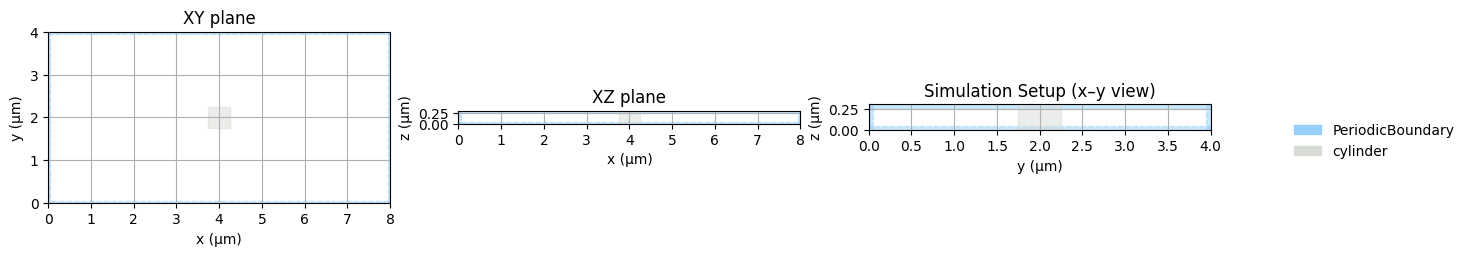

In [435]:
plt.figure(figsize=(8, 6))
fdtdx.plot_setup(config=config, objects = objs)
plt.title("Simulation Setup (x–y view)")
plt.show()

<Figure size 800x600 with 0 Axes>

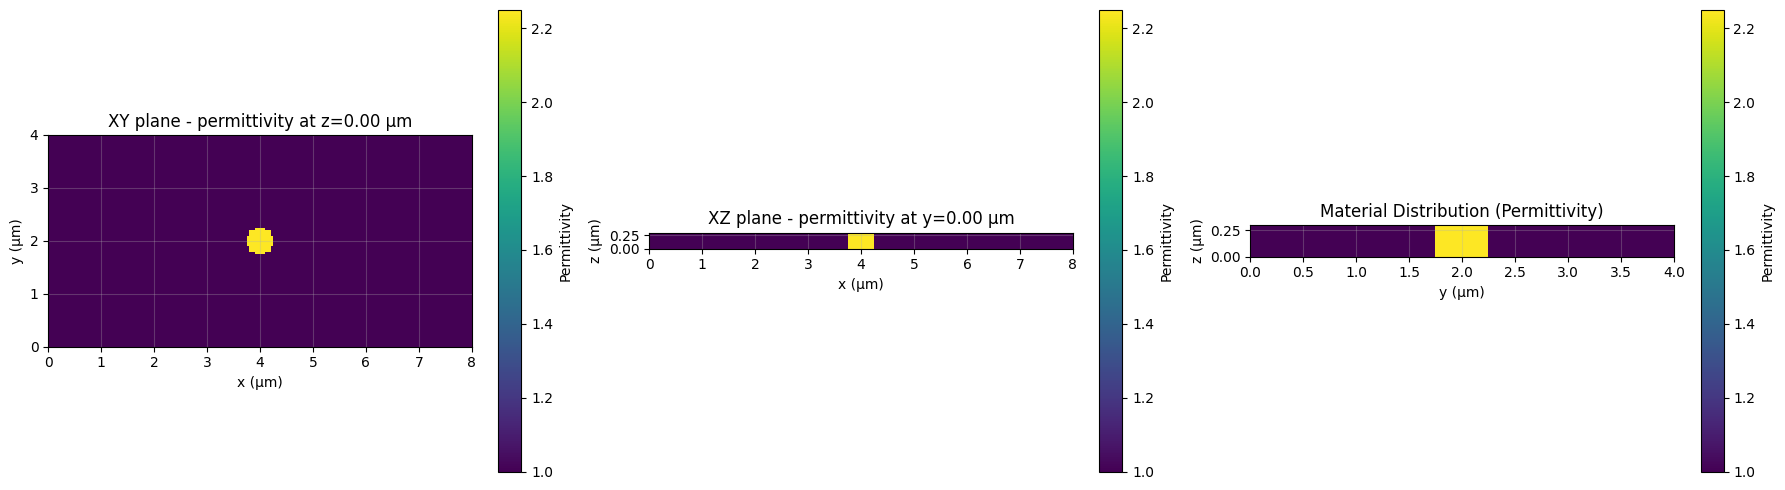

In [437]:
from fdtdx.utils.plot_material import plot_material


plt.figure(figsize=(8, 6))
plot_material(
    arrays=arrays,
    config=config,
)
plt.title("Material Distribution (Permittivity)")
plt.tight_layout()
plt.show()
